In [1]:
#import the different packages used throughout
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import math
import datetime
import boto3
from os.path import expanduser
import os
import json

%matplotlib inline

In [2]:
#calcuate the distance (in degrees) between 2 points in lat/long
def lat_long_to_arc(lat1,long1,lat2,long2):
    # Convert latitude and longitude to
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    if cos>1: cos=1
    if cos<-1: cos=-1
    arc = math.acos( cos )

    return arc

In [3]:
def find_nearest_box(llat,llon,point):
    D = [lat_long_to_arc(l1,l2,point[0],point[1]) for l1,l2 in zip(llat,llon)]
    return np.argmin(D)
    

In [4]:
def remove_dublicate(Data, Time, labels, month, year):
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    time = pd.DatetimeIndex(Time)
    index = np.argwhere((labels==-1) & (time.month>month))

    Data = np.delete(Data,index,0)
    Time = np.delete(Time,index)
    time = np.delete(time,index)
    labels = np.delete(labels,index)

    for i in range(n_clusters_):
        cluster = Data[labels==i,:]
        tcluster = time[labels==i]
        if month<12:
            if np.amin(np.array(tcluster.month))>month:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]
            elif np.max(tcluster).month>month & np.max(tcluster).day>4:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]
        else:
            if np.amax(np.array(tcluster.month))==1:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]
            elif np.max(tcluster).month==1 & np.max(tcluster).day>4:
                Data = Data[labels!=i,:]
                Time = Time[labels!=i]
                time = time[labels!=i]
                labels = labels[labels!=i]

    return Data, Time, labels

In [ ]:
home = expanduser("~")

with open(os.path.join(home,'creds.json')) as creds_file:
    creds_data = json.load(creds_file)

#Access from S3
s3 = boto3.resource('s3',aws_access_key_id=creds_data['key_id'],
         aws_secret_access_key=creds_data['key_access'],region_name='us-west-2')
bucket = s3.Bucket('himatdata')
home = os.getcwd()

for obj in bucket.objects.filter(Delimiter='', Prefix='Trmm/EPO/2000_08Clustered_Data' ):
        print(obj.key)
        bucket.download_file(obj.key,os.path.join(os.path.join(home,'S3_downloads/',obj.key[9:])))

300
661


Text(0.5,1,'Range of Latent Heat Profiles in Events')

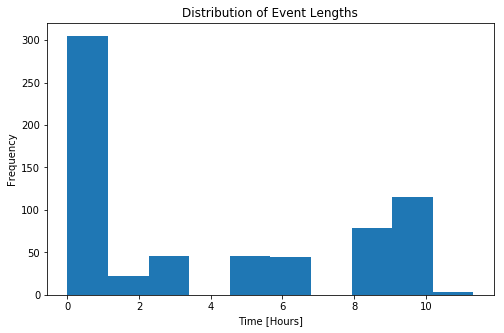

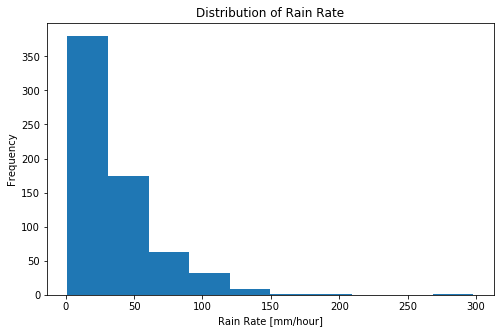

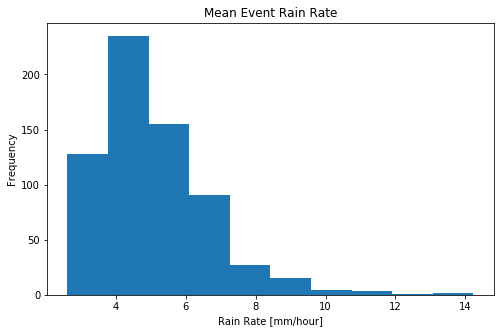

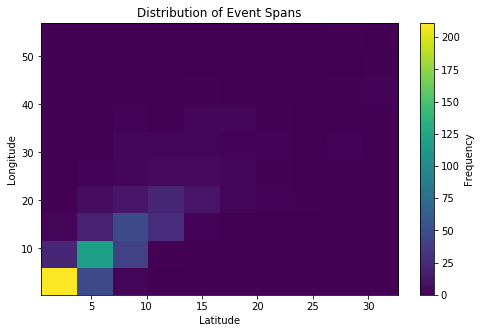

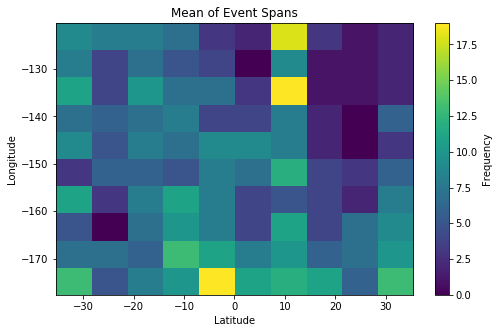

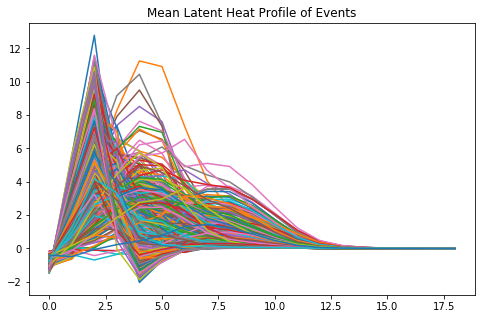

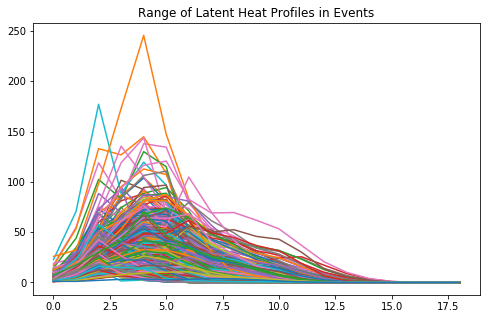

In [5]:
file = xr.open_dataset('S3_downloads/2000_08Clustered_Data.nc4')
Data = file.Data.data #[delta_time, lat, lon, surface_rain, latent heat profile]
labels = file.Labels.data
Time = file.time.data
print(file.eps)
num_clusters_ = np.unique(labels)
num_clusters_ = num_clusters_[num_clusters_>-1]
n_clusters_ = len(num_clusters_)
print(n_clusters_)
cluster_spans = np.zeros((len(Data[0,:]),n_clusters_))
cluster_means = np.zeros((len(Data[0,:]),n_clusters_))
for i in range(n_clusters_):
    cluster = Data[labels==num_clusters_[i],:]
    cluster_spans[:,i] = np.amax(cluster,axis=0)-np.amin(cluster,axis=0)
    cluster_means[:,i] = np.nanmean(cluster,axis=0)

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_spans[0,:])
plt.title('Distribution of Event Lengths')
plt.xlabel('Time [Hours]')
plt.ylabel('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_spans[3,:])
plt.title('Distribution of Rain Rate')
plt.xlabel('Rain Rate [mm/hour]')
plt.ylabel('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist(cluster_means[3,:])
plt.title('Mean Event Rain Rate')
plt.xlabel('Rain Rate [mm/hour]')
plt.ylabel('Frequency')


fig = plt.figure(figsize=(8,5))
plt.hist2d(cluster_spans[1,:],cluster_spans[2,:])
plt.title('Distribution of Event Spans')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar().set_label('Frequency')

fig = plt.figure(figsize=(8,5))
plt.hist2d(cluster_means[1,:],cluster_means[2,:])
plt.title('Mean of Event Spans')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar().set_label('Frequency')

fig = plt.figure(figsize=(8,5))
plt.plot(cluster_means[4:,:]);
plt.title('Mean Latent Heat Profile of Events')

fig = plt.figure(figsize=(8,5))
plt.plot(cluster_spans[4:,:]);
plt.title('Range of Latent Heat Profiles in Events')



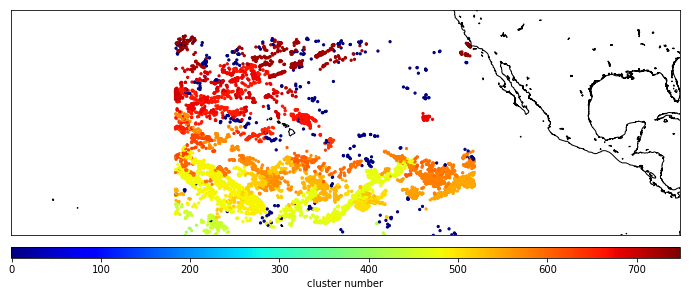

In [7]:
bbox = [0,40,150,280]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines
m.drawcoastlines()

time = pd.DatetimeIndex(Time)
indices = np.argwhere((time<datetime.datetime(2000,8,4)) & (time>datetime.datetime(2000,7,30)))
test = time.day
# indices = np.argwhere((Data[:,1]>15))

#indices = np.argwhere(labels==709)

llat = Data[indices,1]
llon = Data[indices,2]
clusnum = Data[indices,0]
clusnum = labels[indices]

cs = m.scatter(360+llon,llat, latlon=True, c=clusnum, s=5,cmap='jet')
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('cluster number')


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

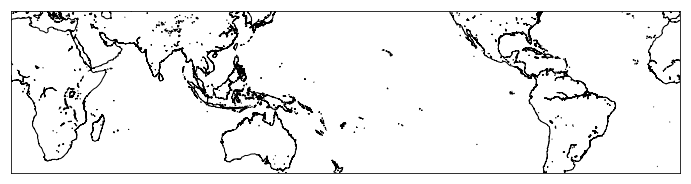

In [30]:
bbox = [-40,40,0,360]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines
m.drawcoastlines()

Lat_Boxes = range(-35,35,2)
Lon_Boxes = range(-180,-120,2)

llat, llon = np.meshgrid(Lat_Boxes,Lon_Boxes)
llat = llat.flatten()
llon = llon.flatten()

events_count = np.zeros((len(llat)))

for i in range(n_clusters_):
    cluster = Data[labels==i,:]
    cluster = np.unique(cluster[:,1:3],axis=0)
    incluster = np.zeros(len(llat))
    for j in range(len(cluster)):
        ind_near = find_nearest_box(llat,llon,cluster[j,:])
        incluster[ind_near] = 1
    events_count += incluster


llat = llat[events_count!=0]
llon = llon[events_count!=0]
events_count = events_count[events_count!=0]

cs = m.scatter(llon.flatten(),llat.flatten(), latlon=True, c=events_count.flatten(), s=25,cmap='jet')
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('event count')


6.490277777777806
722.4594444444444 715.9691666666666
6.492500000000007
369.34833333333336 362.85583333333335
6.463333333333367
698.0661111111111 691.6027777777778
6.473611111111111
16.25 9.776388888888889
6.458055555555518
463.7 457.24194444444447
6.452777777777783
204.97944444444445 198.52666666666667
6.476111111111095
558.0638888888889 551.5877777777778
8.01777777777778
229.36527777777778 221.3475
6.49666666666667
157.81194444444444 151.31527777777777
6.439166666666665
344.97805555555556 338.5388888888889
6.469444444444434
675.2486111111111 668.7791666666667
0.017499999999998295
105.71333333333334 105.69583333333334
6.415555555555557
628.0469444444444 621.6313888888889
4.889444444444393
650.8777777777777 645.9883333333333
4.888333333333321
556.5069444444445 551.6186111111111


TypeError: You must first set_array for mappable

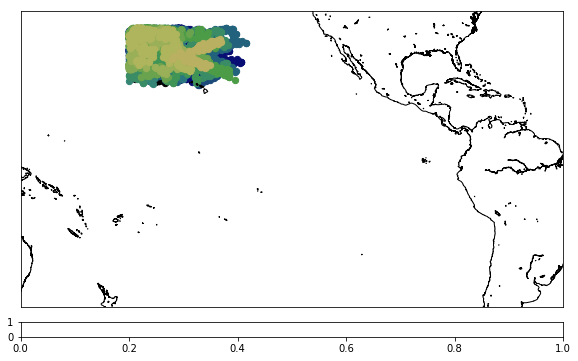

In [29]:
#region overwhich to show the plot
bbox = [-40,40,150,310]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
labels_min = 600
labels_max = 615

#plot the location of rain for the individual clusters (colored by cluster)
for ii in range(600,615):
    cluster = Data[labels==num_clusters_[ii],:]
    print(np.amax(cluster[:,0])-np.amin(cluster[:,0]))
    print(np.amax(cluster[:,0]),np.amin(cluster[:,0]))
    color_interp = np.interp(ii,[labels_min,labels_max],[0,200])
    cs = m.scatter(cluster[:,2],cluster[:,1],s=40,marker='o',color=cmap(int(color_interp)),latlon=True)
#     m.scatter(cluster[:,2],cluster[:,1],s=40,marker='o',c=cluster[:,0],latlon=True)
    
cbar = m.colorbar(cs,location='bottom',pad="5%")